
The R0 is between 2 and 6, meaning each infected person infects 2–6 others, which can cause the number of infected to double every few days.

In [ ]:

command_str = '{sys.executable} -m pip install --upgrade statsmodels'.format(sys=sys)
print(command_str)
!{command_str}

In [1]:

%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py

from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
pandemic_df = s.load_object('pandemic_df')
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

%pprint
dir()

C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\ipynb\Corona Virus Exploration.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']
Pretty printing has been turned OFF


['Config', 'In', 'Out', 'RandomForestClassifier', 'SequenceMatcher', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '_dh', '_i', '_i1', '_ih', '_ii', '_iii', '_oh', 'bs', 'check_4_doubles', 'check_for_typos', 'conjunctify_list', 'copyfile', 'csv', 'encoding', 'example_iterrows', 'exit', 'filepath_regex', 'get_classifier', 'get_column_descriptions', 'get_data_structs_df', 'get_datastructure_prediction', 'get_dir_tree', 'get_git_lfs_track_commands', 'get_importances', 'get_input_sample', 'get_ipython', 'get_max_rsquared_adj', 'get_module_version', 'get_notebook_path', 'get_page_tables', 'get_specific_gitignore_files', 'get_struct_name', 'humanize_bytes', 'io', 'ipykernel', 'json', 'jupyter_config_dir', 'math', 'notebook_path', 'notebookapp', 'nx', 'os', 'pandemic_df', 'pd', 'pickle', 'plt', 'preprocess_data', 'print_all_files_ending_starting_with', 'print_all_files_ending_with', 'print_all_files_s

In [7]:

!start %windir%\explorer.exe "{os.path.abspath(os.path.dirname(notebook_path))}"

In [2]:

pandemic_df

,Disease,Transmission,R0,Case_fatality_ratio,Hospitalized_cases_sent_to_ICU,Asymptomatic_transmission,Year_vaccine_available,R0_high,R0_low,CFR_high,CFR_low
0,Pertussis,Airborne droplet,9.9-11.5,4%,NaN,NaN,1930s,11.50,9.90,4.000,4.000
1,Diphtheria,Airborne droplet,6-7,5-10%,NaN,NaN,1923,7.00,6.00,10.000,5.000
2,Measles,Airborne,12-18,0.1-0.2%,NaN,NaN,1963,18.00,12.00,0.200,0.100
3,Smallpox,Airborne droplet,5-7,30% (variola major),NaN,NaN,1797,7.00,5.00,30.000,30.000
4,Rubella,Airborne droplet,5-7,3-6% (developing world),NaN,NaN,1970,7.00,5.00,6.000,3.000
5,Mumps,Airborne droplet,4-7,0.01%,NaN,NaN,1967,7.00,4.00,0.010,0.010
6,SARS,Airborne droplet,2-5¹,9.6%¹,NaN,No,NaN,5.00,2.00,9.600,9.600
7,MERS,Airborne droplet,<1¹,34%¹,NaN,No,NaN,1.00,1.00,34.000,34.000
8,Swine flu (A/H1N1),Airborne,1.64-1.88⁷,0.026%⁸,NaN,Yes,2009,1.88,1.64,0.026,0.026
9,Seasonal flu,Airborne,1-2,< 0.1%,5-10%⁵,Yes,seasonal,2.00,1.00,0.100,0.100


In [5]:

pandemic_df = s.load_object('pandemic_df')
pandemic_df.loc[12, 'R0_low'] = 2
pandemic_df.loc[12, 'R0_high'] = 6
s.store_objects(pandemic_df=pandemic_df)

Pickling to C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\pickle\pandemic_df.pickle


In [46]:

column_description_dict = s.load_object('column_description_dict')

In [47]:

def get_column_description(column_name):
    if column_name in column_description_dict:
        column_description = column_description_dict[column_name]
    else:
        column_description = re.sub('^pf_', 'Personal Freedom:_', str(column_name), 1)
        column_description = re.sub('^hf_', 'Human Freedom:_', str(column_description), 1)
        column_description = re.sub('^ef_', 'Economic Freedom:_', str(column_description), 1)
        column_list = column_description.split('_')
        descr_list = []
        for word in column_list:
            descr_list.append(word[0].upper()+word[1:])
        column_description = ' '.join(descr_list)
        column_description_dict[column_name] = column_description
        s.store_objects(column_description_dict=column_description_dict)
    
    return column_description

In [8]:

for column_name in pandemic_df.columns:
    print(column_name, get_column_description(column_name=column_name))

Disease Disease Name
Transmission Transmission Method
R0 Basic Reproduction Number
Case_fatality_ratio Case Fatality Ratio
Hospitalized_cases_sent_to_ICU Hospitalized Cases Sent To ICU
Asymptomatic_transmission Asymptomatic Transmission
Year_vaccine_available Year Vaccine Available
R0_high Basic Reproduction Number (High Range)
R0_low Basic Reproduction Number (Low Range)
CFR_high Case Fatality Ratio (High Range)
CFR_low Case Fatality Ratio (Low Range)


In [51]:

svg_dir = os.path.join(s.saves_folder, 'svg')
os.makedirs(name=svg_dir, exist_ok=True)

In [59]:

def show_linear_scatterplot(merged_df, columns_list, ev_min_str=None, ev_max_str=None, rv_min_str=None, rv_max_str=None):
    ev_column_name = columns_list[0]
    rv_column_name = columns_list[1]
    explanatory_variable = get_column_description(ev_column_name)
    response_variable = get_column_description(rv_column_name)
    if (ev_min_str is None):
        ev_min_str = 'minimum {}'.format(explanatory_variable)
    if (ev_max_str is None):
        ev_max_str = 'maximum {}'.format(explanatory_variable)
    if (rv_min_str is None):
        rv_min_str = 'minimum {}'.format(response_variable)
    if (rv_max_str is None):
        rv_max_str = 'maximum {}'.format(response_variable)
    
    df = merged_df.copy()
    columns_list = [ev_column_name, rv_column_name]
    df = df[columns_list].dropna()
    ev_max = df[ev_column_name].max()
    ev_min = df[ev_column_name].min()
    rv_min = df[rv_column_name].min()
    rv_max = df[rv_column_name].max()
    ev_max_labeled = False
    ev_min_labeled = False
    rv_min_labeled = False
    rv_max_labeled = False
    
    # First order (linear) scatterplot
    fig1_fig = plt.figure(figsize=(12,8))
    merge_axes_subplot = plt.scatter(x=df[ev_column_name].tolist(), y=df[rv_column_name].tolist(), s=None, c=None, marker=None, cmap=None,
                                     norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None,
                                     plotnonfinite=False, data=df)
    xlabel_text = plt.xlabel('{}'.format(explanatory_variable))
    ylabel_text = plt.ylabel('{}'.format(response_variable))
    
    # Add annotations
    for label, x, y in zip(df.index, df[ev_column_name], df[rv_column_name]):
        if (x == ev_min):
            if not ev_min_labeled:
                ev_min_labeled = True
                annotation = plt.annotate('{} ({})'.format(label, ev_min_str), xy=(x, y), xytext=ev_min_xytext, **kwargs)
        elif (x == ev_max):
            if not ev_max_labeled:
                ev_max_labeled = True
                annotation = plt.annotate('{} ({})'.format(label, ev_max_str), xy=(x, y), xytext=ev_max_xytext, **kwargs)
        elif (y == rv_min):
            if not rv_min_labeled:
                rv_min_labeled = True
                annotation = plt.annotate('{} ({})'.format(label, rv_min_str), xy=(x, y), xytext=rv_min_xytext, **kwargs)
        elif (y == rv_max):
            if not rv_max_labeled:
                rv_max_labeled = True
                annotation = plt.annotate('{} ({})'.format(label, rv_max_str), xy=(x, y), xytext=rv_max_xytext, **kwargs)
        elif (label == 'SARS'):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(50, -20), **kwargs)
        elif ('Kong' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, 120), **kwargs)
        elif ('Swine' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-50, 100-2.7842095), **kwargs)
        elif ('Seasonal' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-25, 70-1.9397546), **kwargs)
        elif ('Spanish' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-59, 128), **kwargs)
        elif ('19' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-85, 25), **red_kwargs)
        '''else:
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=ev_min_xytext, **kwargs)'''
    
    # Add r-squared
    x = df[ev_column_name].values
    y = df[rv_column_name].values
    plt.text(17.4, 34.4, r'$r^2 = {0:.2}$'.format(stats.pearsonr(x, y)[0] ** 2), fontsize=20, alpha=0.25,
             horizontalalignment='center', verticalalignment='center')
    plt.suptitle(t='Relative Deadliness and Infectiousness of the Wuhan Flu Pandemic', x=0.5, y=0.91)
    left, right = plt.xlim()
    bottom, top = plt.ylim()
    file_path = os.path.join(svg_dir, 'pandemic.svg')
    plt.savefig(file_path)
    with open(file_path, 'r') as f:
        xml_str = f.read()
        d_regex = re.compile('d="([^"\r\n]+)[\r\n]+')
        while d_regex.search(xml_str):
            xml_str = d_regex.sub(r'd="\g<1>', xml_str)
        with open(file_path, 'w') as f:
            print(xml_str.strip(), file=f)
    
    return file_path, left, right, bottom, top

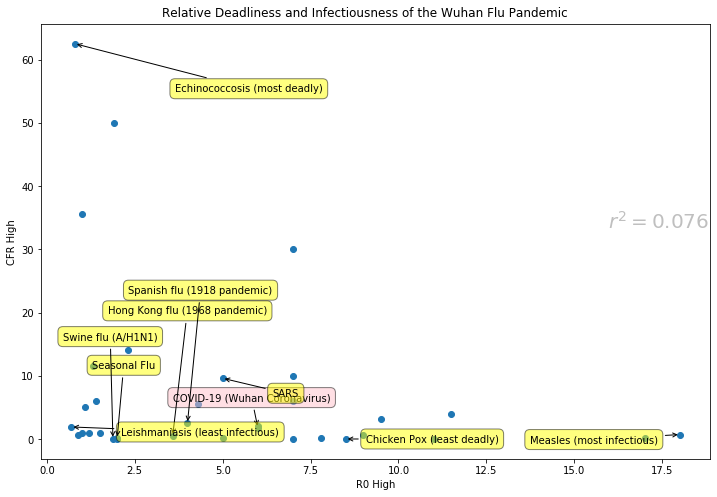

In [60]:

#pandemic_df = s.load_object('pandemic_df')
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
red_kwargs = dict(textcoords='offset points', ha='left', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.5', fc='pink', alpha=0.5),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ev_column_name = 'R0_high'
rv_column_name = 'CFR_high'

ev_min_str = 'least infectious'
ev_max_str = 'most infectious'
rv_min_str = 'least deadly'
rv_max_str = 'most deadly'
ev_min_xytext = (50, -10)
ev_max_xytext = (-150, -10)
rv_min_xytext = (20, -5)
rv_max_xytext = (100, -50)
columns_list = [ev_column_name, rv_column_name]
file_path, left, right, bottom, top = show_linear_scatterplot(pandemic_df, columns_list, ev_min_str=ev_min_str,
                                                              ev_max_str=ev_max_str, rv_min_str=rv_min_str,
                                                              rv_max_str=rv_max_str)
!start %windir%\explorer.exe "{os.path.abspath(os.path.dirname(file_path))}"

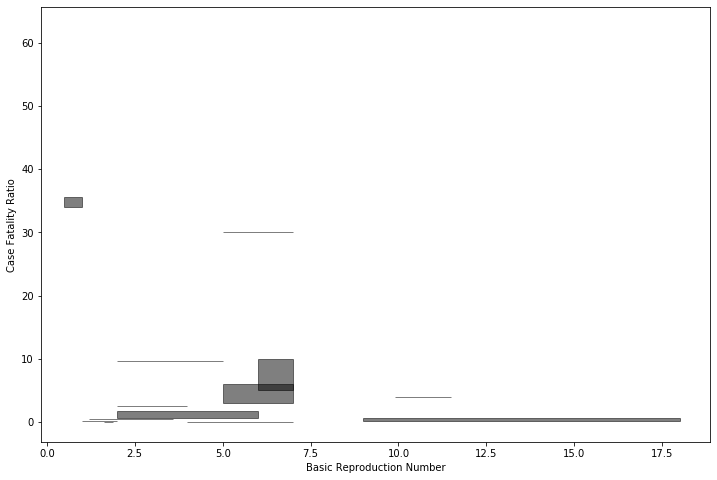

In [63]:

import matplotlib

columns_list = ['R0_high', 'R0_low', 'CFR_high', 'CFR_low']
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
match_series = (pandemic_df.index == 'Rubella')
for Disease, row_series in pandemic_df[columns_list].iterrows():
    R0_high = row_series['R0_high']
    R0_low = row_series['R0_low']
    CFR_high = row_series['CFR_high']
    CFR_low = row_series['CFR_low']
    rect = matplotlib.patches.Rectangle((R0_low, CFR_low), R0_high-R0_low, CFR_high-CFR_low, color='black', alpha=0.5)
    ax.add_patch(rect)
    #annotation = plt.annotate('{}'.format(Disease), xy=(int((R0_high+R0_low)/2), int((CFR_high+CFR_low)/2)), xytext=(-85, 20), **red_kwargs)
plt.xlim(left, right)
bottom, top = plt.ylim(bottom, top)
xlabel_text = plt.xlabel('Basic Reproduction Number')
ylabel_text = plt.ylabel('Case Fatality Ratio')

In [178]:

Disease, R0_high, R0_low, CFR_high, CFR_low

('Rubella', 7.0, 5.0, 6.0, 3.0)

In [ ]:

merge_axes_subplot = plt.scatter(x=df[ev_column_name].tolist(), y=df[rv_column_name].tolist(), s=None, c=None, marker=None, cmap=None,
                                 norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None,
                                 plotnonfinite=False, data=df)


---
# Create the DataFrame

In [5]:

pandemic_df.set_index('Disease', drop=True, inplace=True)
s.store_objects(pandemic_df=pandemic_df)

Pickling to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\pickle\pandemic_df.pickle


In [12]:

pandemic_df

,Transmission,R0,Case_fatality_ratio,Hospitalized_cases_sent_to_ICU,Asymptomatic_transmission,Year_vaccine_available,R0_high,R0_low,CFR_high,CFR_low
Disease,,,,,,,,,,
Pertussis,Airborne droplet,9.9-11.5,4%,NaN,NaN,1930s,11.50,9.90,4.000,4.000
Diphtheria,Airborne droplet,6-7,5-10%,NaN,NaN,1923,7.00,6.00,10.000,5.000
Measles,Airborne,12-18,0.1-0.2%,NaN,NaN,1963,18.00,12.00,0.200,0.100
Smallpox,Airborne droplet,5-7,30% (variola major),NaN,NaN,1797,7.00,5.00,30.000,30.000
Rubella,Airborne droplet,5-7,3-6% (developing world),NaN,NaN,1970,7.00,5.00,6.000,3.000
Mumps,Airborne droplet,4-7,0.01%,NaN,NaN,1967,7.00,4.00,0.010,0.010
SARS,Airborne droplet,2-5¹,9.6%¹,NaN,No,NaN,5.00,2.00,9.600,9.600
MERS,Airborne droplet,<1¹,34%¹,NaN,No,NaN,1.00,1.00,34.000,34.000
Swine flu (A/H1N1),Airborne,1.64-1.88⁷,0.026%⁸,NaN,Yes,2009,1.88,1.64,0.026,0.026


In [11]:

csv_name = 'COVID-19'
csv_path = os.path.abspath(os.path.join(s.data_csv_folder, '{}.csv'.format(csv_name)))
covid19_df = pd.read_csv(csv_path, encoding=s.encoding_type, header=[0, 1])
covid19_df

,updated 9th Mar,deaths per day (global),total news mentions (millions),news mentions per death,Fatality Rate,Infectiousness,annual global fatalities,new cases per year,days of outbreak,fatalty notes,source,URL
,Unnamed: 0_level_1,rounded,data retrieved 3rd Mar 2020,Unnamed: 3_level_1,CFR %,R0,latest data year,latest data year,Unnamed: 8_level_1,Unnamed: 9_level_1,Unnamed: 10_level_1,Unnamed: 11_level_1
0,Tuberculosis,"3,014","2,970,000",986,14.00%,2.3,"1,100,000","9,019,296",NaN,2015,The Lancet,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
1,Hepatitis B,"2,430","182,000",75,0.10%,5.0,"887,000","118,976,405",NaN,2015,WHO,https://www.who.int/news-room/fact-sheets/deta...
2,Pneumonia,"2,216","5,000,000","2,257",5.00%,1.1,"808,694",-,NaN,child deaths,WHO,https://www.who.int/news-room/fact-sheets/deta...
3,HIV,"2,110","40,000,000","18,961",2.10%,6.0,"770,000","1,865,245",NaN,2018,US Gov,https://www.hiv.gov/hiv-basics/overview/data-a...
4,Malaria,"2,002","5,970,000","2,983",0.20%,17.0,"730,550","213,098,073",NaN,"unspecified strain, 555,800-904,000 range",The Lancet,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
5,Shigellosis,"1,644","3,770",2,1.00%,1.5,"600,000","190,849,501",NaN,NaN,CDC,https://wwwnc.cdc.gov/travel/yellowbook/2020/t...
6,Rotavirus,"1,233","60,000",49,0.70%,0.9,"450,000",-,NaN,2008. children <5,CDC,http://www.cdc.gov/rotavirus/surveillance.html...
7,Seasonal Flu,"1,027","202,000",197,0.10%,1.0,"375,000","4,000,000",NaN,"range 250-500,000.",WHO,http://www.who.int/mediacentre/factsheets/fs21...
8,Norovirus,548,"588,000","1,073",0.10%,7.8,"200,000","684,850,131",NaN,NaN,CDC,https://www.cdc.gov/norovirus/downloads/global...


In [10]:

name_regex = re.compile(r'[^0-9A-Za-z]+')
[name_regex.sub('_', '{} {}'.format(cn_tuple[0], cn_tuple[1]).lower()) for cn_tuple in covid19_df.columns]

['updated_9th_mar_unnamed_0_level_1', 'deaths_per_day_global_rounded', 'total_news_mentions_millions_data_retrieved_3rd_mar_2020', 'news_mentions_per_death_unnamed_3_level_1', 'fatality_rate_cfr_', 'infectiousness_r0', 'annual_global_fatalities_latest_data_year', 'new_cases_per_year_latest_data_year', 'days_of_outbreak_unnamed_8_level_1', 'fatalty_notes_unnamed_9_level_1', 'source_unnamed_10_level_1', 'url_unnamed_11_level_1']

In [13]:

covid19_df.columns = ['Disease', 'deaths_per_day_global_rounded', 'total_news_mentions_millions_data_retrieved_3rd_mar_2020',
                      'news_mentions_per_death', 'CFR_low', 'R0_low', 'annual_global_fatalities_latest_data_year',
                      'new_cases_per_year_latest_data_year', 'days_of_outbreak', 'fatalty_notes', 'source', 'url']
covid19_df.set_index('Disease', drop=True, inplace=True)
s.store_objects(covid19_df=covid19_df)

Pickling to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\pickle\covid19_df.pickle


In [27]:

pandemic_df = s.load_object('pandemic_df')
pandemic_df.index = ['Pertussis', 'Diphtheria', 'Measles', 'Smallpox', 'Rubella', 'Mumps', 'SARS', 'MERS', 'Swine flu (A/H1N1)',
                     'Seasonal Flu', 'Hong Kong flu (1968 pandemic)', 'Spanish flu (1918 pandemic)', 'COVID-19 (Wuhan Coronavirus)']
s.store_objects(pandemic_df=pandemic_df)

Pickling to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\pickle\pandemic_df.pickle


In [42]:

pandemic_df = s.load_object('pandemic_df')
covid19_df = s.load_object('covid19_df')
pandemic_df = pd.merge(left=pandemic_df, right=covid19_df, how='outer', left_index=True, right_index=True, suffixes=('_old', '_new'))
pandemic_df.columns = ['Transmission', 'R0', 'Case_fatality_ratio', 'Hospitalized_cases_sent_to_ICU', 'Asymptomatic_transmission',
                       'Year_vaccine_available', 'R0_high', 'R0_low', 'CFR_high', 'CFR_low', 'deaths_per_day_global_rounded',
                       'total_news_mentions_millions_data_retrieved_3rd_mar_2020', 'news_mentions_per_death', 'CFR_new',
                       'R0_new', 'annual_global_fatalities_latest_data_year', 'new_cases_per_year_latest_data_year',
                       'days_of_outbreak', 'fatalty_notes', 'source', 'url']
columns_list = sorted([cn for cn in pandemic_df.columns if ('_low' in cn) or ('_high' in cn) or ('_new' in cn)])
num_regex = re.compile(r'[^0-9.]+')
for disease_name, row_series in pandemic_df[columns_list].iterrows():
    CFR_high = row_series['CFR_high']
    CFR_low = row_series['CFR_low']
    CFR_new = row_series['CFR_new']
    if str(CFR_new) != 'nan':
        CFR_new = float(num_regex.sub('', str(CFR_new)))
    if str(CFR_high) == 'nan':
        pandemic_df.loc[disease_name, 'CFR_high'] = CFR_new
    if str(CFR_low) == 'nan':
        pandemic_df.loc[disease_name, 'CFR_low'] = CFR_new
    if str(CFR_new) != 'nan':
        if CFR_new < CFR_low:
            pandemic_df.loc[disease_name, 'CFR_low'] = CFR_new
        elif CFR_new > CFR_high:
            pandemic_df.loc[disease_name, 'CFR_high'] = CFR_new
    R0_high = row_series['R0_high']
    R0_low = row_series['R0_low']
    R0_new = row_series['R0_new']
    if str(R0_new) != 'nan':
        R0_new = float(num_regex.sub('', str(R0_new)))
    if str(R0_high) == 'nan':
        pandemic_df.loc[disease_name, 'R0_high'] = R0_new
    if str(R0_low) == 'nan':
        pandemic_df.loc[disease_name, 'R0_low'] = R0_new
    if str(R0_new) != 'nan':
        if R0_new < R0_low:
            pandemic_df.loc[disease_name, 'R0_low'] = R0_new
        elif R0_new > R0_high:
            pandemic_df.loc[disease_name, 'R0_high'] = R0_new
columns_list = ['Transmission', 'R0', 'Case_fatality_ratio', 'Hospitalized_cases_sent_to_ICU', 'Asymptomatic_transmission',
                'Year_vaccine_available', 'R0_high', 'R0_low', 'CFR_high', 'CFR_low', 'deaths_per_day_global_rounded',
                'total_news_mentions_millions_data_retrieved_3rd_mar_2020', 'news_mentions_per_death',
                'annual_global_fatalities_latest_data_year', 'new_cases_per_year_latest_data_year',
                'days_of_outbreak', 'fatalty_notes', 'source', 'url']
pandemic_df = pandemic_df[columns_list]
pandemic_df.sample(5).T.sample(6).T

,source,url,CFR_high,Asymptomatic_transmission,deaths_per_day_global_rounded,R0_low
Rubella,NaN,NaN,6,NaN,NaN,5
Typhoid,CDC,http://www.cdc.gov/nczved/divisions/dfbmd/dise...,1,NaN,396,1.2
Leishmaniasis,BMC Public Health,https://bmcpublichealth.biomedcentral.com/arti...,1.9,NaN,55,0.7
Ebola,NaN,https://www.manchestereveningnews.co.uk/news/w...,50,NaN,5.3,1.9
Measles,Oxford Vaccine Group,http://vk.ovg.ox.ac.uk/vk/measles,0.7,NaN,247,9


In [31]:

covid19_df = s.load_object('covid19_df')
covid19_df.index = ['Tuberculosis', 'Hepatitis B', 'Pneumonia', 'HIV ', 'Malaria ', 'Shigellosis', 'Rotavirus', 'Seasonal Flu',
                    'Norovirus', 'Whooping Cough', 'Typhoid', 'Cholera', 'Meningitis', 'Measles', 'Rabies ', 'Yellow Fever',
                    'Leishmaniasis', 'Echinococcosis', 'COVID-19 (Wuhan Coronavirus)', 'Dengue Fever', 'Hepatitis A',
                    'Chicken Pox', 'Sleeping Sickness', 'Ebola', 'SARS', 'MERS']
s.store_objects(covid19_df=covid19_df)

Pickling to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\pickle\covid19_df.pickle


In [30]:

pandemic_df = s.load_object('pandemic_df')
covid19_df = s.load_object('covid19_df')
check_for_typos(left_list=covid19_df.index.tolist(), right_list=pandemic_df.index.tolist(), verbose=False).sort_values('left_item')

,left_item,right_item,max_similarity
18,COVID-19 (Wuhan Coronavirus),COVID-19 (Wuhan Coronavirus),1.000000
21,Chicken Pox,Seasonal Flu,0.260870
11,Cholera,Diphtheria,0.470588
19,Dengue Fever,Seasonal Flu,0.333333
23,Ebola,Rubella,0.500000
17,Echinococcosis,Pertussis,0.260870
3,HIV,Seasonal Flu,0.125000
20,Hepatitis A,Pertussis,0.400000
1,Hepatitis B,Pertussis,0.400000
16,Leishmaniasis,Pertussis,0.454545


In [2]:

def get_page_soup(page_url):
    with urllib.request.urlopen(page_url) as response:
        page_html = response.read()
    page_soup = bs(page_html, 'html.parser')
    
    return page_soup

In [21]:

tables_url = 'https://www.zorinaq.com/pub/ncov-comparison.html'
ncov_path = os.path.join(s.data_folder, 'html', 'ncov-comparison.html')
#page_soup = get_page_soup(tables_url)
tables_list = get_page_tables(tables_url)

[(0, (13, 7))]


In [54]:

import numpy as np

pandemic_df = tables_list[0].copy()
pandemic_df.columns = ['Disease', 'Transmission', 'R0', 'Case_fatality_ratio', 'Hospitalized_cases_sent_to_ICU',
                       'Asymptomatic_transmission', 'Year_vaccine_available']

def f(x):
    result = re.sub(r' *\(', ' (', str(x))
    
    return result

pandemic_df.Disease = pandemic_df.Disease.map(f)

def f(x):
    result = re.sub(r'⁹', '', str(x))
    
    return result

pandemic_df.Transmission = pandemic_df.Transmission.map(f)
pandemic_df['R0_high'] = np.nan

def f(x):
    result = str(x).split('-')[-1]
    result = re.sub(r'[^0-9.]+', '', result)
    
    return float(result)

pandemic_df['R0_high'] = pandemic_df.R0.map(f)
pandemic_df['R0_low'] = np.nan

def f(x):
    result_list = str(x).split('-')
    if len(result_list) < 3:
        result = result_list[0]
    else:
        result = result_list[1].split(' ')[-1]
    result = re.sub(r'[^0-9.]+', '', result)
    
    return float(result)

pandemic_df['R0_low'] = pandemic_df.R0.map(f)
pandemic_df['CFR_high'] = np.nan

def f(x):
    result = str(x).split('-')[-1]
    result = re.sub(r'[^0-9.]+', '', result)
    
    return float(result)

pandemic_df['CFR_high'] = pandemic_df.Case_fatality_ratio.map(f)
pandemic_df['CFR_low'] = np.nan

def f(x):
    result_list = str(x).split('-')
    result = result_list[0]
    result = re.sub(r'[^0-9.]+', '', result)
    
    return float(result)

pandemic_df['CFR_low'] = pandemic_df.Case_fatality_ratio.map(f)
#print(pandemic_df.R0.unique().tolist())
#print(pandemic_df.R0.map(f).unique().tolist())
s.store_objects(pandemic_df=pandemic_df)
pandemic_df.sample(5).T

Pickling to C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\pickle\pandemic_df.pickle


,9,0,7,4,12
Disease,Seasonal flu,Pertussis,MERS,Rubella,Novel coronavirus (2019-nCoV)
Transmission,Airborne,Airborne droplet,Airborne droplet,Airborne droplet,Airborne droplet
R0,1-2,9.9-11.5,<1¹,5-7,1.4-2.5² 2.47-2.86⁶
Case_fatality_ratio,< 0.1%,4%,34%¹,3-6% (developing world),1.8%⁴
Hospitalized_cases_sent_to_ICU,5-10%⁵,NaN,NaN,NaN,23%³
Asymptomatic_transmission,Yes,NaN,No,NaN,Suspected¹⁰
Year_vaccine_available,seasonal,1930s,NaN,1970,NaN
R0_high,2,11.5,1,7,2.86
R0_low,1,9.9,1,5,2.47
CFR_high,0.1,4,34,6,1.8
